In [1]:
import importlib
def rl():
    importlib.reload(Di)

In [2]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [3]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
import torch
import gpytorch

In [5]:
import pyarrow as pa
import pyarrow.parquet as pq

In [6]:
from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [7]:
import Di

In [8]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

In [10]:
env = env_list[5]
print(env)

NaCl


In [11]:
df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

In [18]:
ids = list(df.columns[3:])

In [19]:
env + '_matsui_geno_t.pt'

'NaCl_matsui_geno_t.pt'

In [20]:
geno_t = torch.load(env + '_matsui_geno_t.pt')

In [21]:
geno_t

tensor([[1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [22]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [23]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

In [24]:
pheno = pheno.set_index('geno')

In [25]:
pheno = pheno.loc[ids]

### Set up

In [35]:
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 8 GPUs.


In [36]:
output_device = torch.device('cuda:0')

### Test Parallel

In [37]:
inds_sub = np.where(np.array(pheno.pheno < -0.9) == False)[0]

In [38]:
sub = np.random.choice(inds_sub, 20000)

In [39]:
sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5000)

In [40]:
train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

In [41]:
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [44]:
def d(geno1, geno2):
  """build distance tensor between two sets of genotypes
  geno1, geno2: n x L, m x L torch tensors
  
  """
  geno1_h0 = 1.*(geno1 == 0.)
  geno1_h1 = 1.*(geno1 == 2.)
  geno2_h0 = 1.*(geno2 == 0.)
  geno2_h1 = 1.*(geno2 == 2.)
  S1 = torch.matmul(geno1%2, torch.transpose(geno2%2, 0, 1))
  S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
  D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1)) 
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
  D1 = L - S1 - S2 - D2

  return torch.stack((S1, S2, D1, D2))


In [45]:
def k(log_lda, log_eta, dvec):
    """
    log_lda, log_eta -- torch tensors
    dvec -- 4 x n x m torch tensor
    """
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    return (((1 + lda + eta)**(dvec[1] - L/2))
          *((1 - lda + eta)**dvec[3])
          *((1 + eta)**(dvec[0] - L/2)) 
          * (1-eta)**dvec[2])


In [46]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class DiKernel(gpytorch.kernels.Kernel):
  """Diploid kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                lda_prior=None, lda_constraint=None, 
                eta_prior=None, eta_constraint=None,
                **kwargs):
      super().__init__(**kwargs)

      # register the raw parameter
      self.register_parameter(
          name='raw_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      self.register_parameter(
          name='raw_eta', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      # set the parameter constraint to be positive, when nothing is specified
      if lda_constraint is None:
          lda_constraint = LessThan(upper_bound=0.)

      if eta_constraint is None:
          eta_constraint = LessThan(upper_bound=0.)

      # register the constraint
      self.register_constraint("raw_lda", lda_constraint)
      self.register_constraint("raw_eta", eta_constraint)

      
  # now set up the 'actual' paramter
  @property
  def lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_lda_constraint.transform(self.raw_lda)

  @property
  def eta(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_eta_constraint.transform(self.raw_eta)

  @lda.setter
  def lda(self, value):
      return self._set_lda(value)

  @eta.setter
  def eta(self, value):
      return self._set_eta(value)

  def forward(self, x1, x2, **params):
    diff = d(x1, x2)
    return k(lda, eta, diff)
#     return k(self.lda, self.eta, diff)
#     return self.eta*diff[0]
#     dvec = diff
#     log_lda = torch.nn.Parameter(torch.tensor(-8.))
#     log_eta = torch.nn.Parameter(torch.tensor(-12.))
#     lda = torch.exp(log_lda)
#     eta = torch.exp(log_eta)
    
#     return (((1 + lda + eta)**(dvec[1] - L/2))
#     *((1 - lda + eta)**dvec[3])
#     *((1 + eta)**(dvec[0] - L/2)) 
#     * (1-eta)**dvec[2])



class DiGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            DiKernel(), device_ids=range(n_devices),
            output_device=output_device
        )

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [47]:
class LinKernel(gpytorch.kernels.Kernel):
  """Additive kernel"""

  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, 
                **kwargs):
      super().__init__(**kwargs)

  def forward(self, x1, x2, **params):
      diff = d(x1, x2)
      return 2*(diff[1] - diff[-1])


# class LinGPModel(gpytorch.models.ExactGP):

#   def __init__(self, train_x, train_y, likelihood):
#     super().__init__(train_x, train_y, likelihood)
#     self.mean_module = gpytorch.means.ConstantMean()
#     self.covar_module = gpytorch.kernels.MultiDeviceKernel(
#             LinKernel(), device_ids=range(n_devices),
#             output_device=output_device
#         )

#   def forward(self, x):
#     mean_x = self.mean_module(x)
#     covar_x = self.covar_module(x)
#     return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class LinGPModel(gpytorch.models.ExactGP):

  def __init__(self, train_x, train_y, likelihood):
    super().__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = LinKernel()

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



In [48]:
ker = LinKernel()

In [50]:
# class DiGPModel(gpytorch.models.ExactGP):

#   def __init__(self, train_x, train_y, likelihood):
#     super().__init__(train_x, train_y, likelihood)
#     self.mean_module = gpytorch.means.ConstantMean()
#     self.covar_module = DiKernel()

#   def forward(self, x):
#     mean_x = self.mean_module(x)
#     covar_x = self.covar_module(x)
#     return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [49]:
# lda = torch.nn.Parameter(torch.tensor(-8.))
# eta = torch.nn.Parameter(torch.tensor(-11.))

lda = torch.nn.Parameter(torch.tensor(-10.6562))
eta = torch.nn.Parameter(torch.tensor(-16.2755))

lda = lda.double()
eta = eta.double()

In [50]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DiGPModel(train_x, train_y, likelihood)
model = model.to(output_device)

In [51]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [52]:
model.eval()
f_preds = model(test_x)

RuntimeError: expected scalar type Double but found Float

In [36]:
f_mean = f_preds.mean.cpu()

In [37]:
f_true = test_y.cpu().numpy()

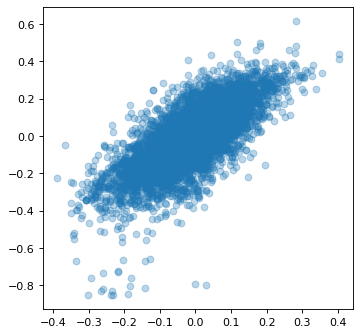

r2 = 0.542350
R2 = 0.530533
mse = 0.014431


In [38]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), f_true, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), f_true)[0]**2)
print('R2 = %f'%r2(f_true, f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), f_true))

In [96]:
rl()

In [97]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.LinGPModel(train_x, train_y, likelihood)
model = model.to(output_device)

In [98]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [101]:
Di.L = L

In [102]:
model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=300, lr=.2)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 184768.453125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 16080.5185546875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 ite

KeyboardInterrupt: 

In [71]:
test_x = test_x.cuda()

In [72]:
model.eval()
with gpytorch.settings.max_cg_iterations(10000): 
    f_preds = model(test_x)

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 10000 iterations with average residual norm 1.0886666774749756 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


KeyboardInterrupt: 

In [324]:
X = torch.cat((train_x, torch.unsqueeze(torch.ones(10000),1).to(output_device)), dim=1)

In [330]:
B = torch.transpose(X, 0, 1)@X

In [332]:
torch.inverse(torch.transpose(X, 0, 1)@X)

RuntimeError: inverse_cuda: For batch 0: U(146,146) is zero, singular U.

In [282]:
f_mean = f_preds.mean.cpu()

In [283]:
f_true = test_y.cpu().numpy()

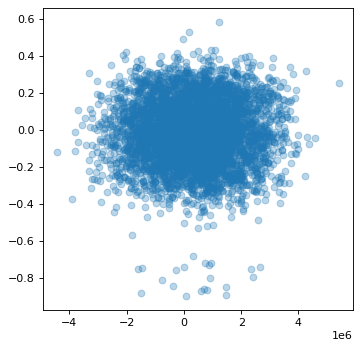

r2 = 0.000019
R2 = -64644759517245.421875
mse = 1956736139264.000000


In [284]:
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), f_true, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), f_true)[0]**2)
print('R2 = %f'%r2(f_true, f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), f_true))

In [268]:
optimizer = torch.optim.AdamW([
    {'params': model.parameters()},
    {'params': lda},
    {'params': eta}
], lr = .01)

In [269]:
# test a forward and back prop

# output = model(train_x)

# loss = -mll(output, train_y)

# loss.backward()

# optimizer.step()

# lda

In [270]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model.train()
likelihood.train()

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},
    {'params': lda},
    {'params': eta}
], lr = .05)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

losses = []

In [43]:
def train(model,
          train_x,
          train_y,
          n_devices,
          output_device,
          n_training_iter,
          lr
):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model.train()
    likelihood.train()

    optimizer = torch.optim.AdamW([
        {'params': model.parameters()},
        {'params': lda},
        {'params': eta}
    ], lr = .05)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    losses = []

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(n_training_iter):
      if i%20==0:
        print(i)
      else: pass
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(train_x)
      # Calc loss and backprop gradients
      loss = -mll(output, train_y)
      loss.backward()
      losses.append(loss.item())    
      optimizer.step()
      del loss
    return losses
    
    
    


#     with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
#          gpytorch.settings.max_preconditioner_size(preconditioner_size):

#         def closure():
#             optimizer.zero_grad()
#             output = model(train_x)
#             loss = -mll(output, train_y)
#             return loss

#         loss = closure()
#         loss.backward()

#         for i in range(n_training_iter):
#             options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
#             loss, _, _, _, _, _, _, fail = optimizer.step(options)

#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#                 i + 1, n_training_iter, loss.item(),
#                 model.covar_module.module.base_kernel.lengthscale.item(),
#                 model.likelihood.noise.item()
#             ))

#             if fail:
#                 print('Convergence reached!')
#                 break

#     print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
#     return model, likelihood

In [272]:
losses = train(model,
    train_x,
    train_y,
    n_devices,
    output_device,
    n_training_iter=100,
    lr=.05
)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80


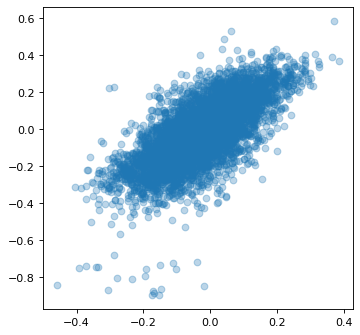

r2 = 0.498611
R2 = 0.494144
mse = 0.015312


In [273]:
test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

f_true = test_y.cpu().numpy()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), f_true, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), f_true)[0]**2)
print('R2 = %f'%r2(f_true, f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), f_true))

In [93]:
import gc

def find_best_gpu_setting(train_x,
                          train_y,
                          n_devices,
                          output_device,
                          preconditioner_size
):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(model, train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1, lr=0.05)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size

# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(train_x, train_y,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

Number of devices: 4 -- Kernel partition size: 0
RuntimeError: Found dtype Float but expected Double


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/lazy/added_diag_lazy_tensor.py:102: NumericalWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  warnings.warn(


Number of devices: 4 -- Kernel partition size: 5000
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 2500
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 1250
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 625
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 10000])
Number of devices: 4 -- Kernel partition size: 313
RuntimeError: The kernel MultiDeviceKernel is not equipped to handle and diag. Expected size torch.Size([10000]). Got size torch.Size([10000, 